## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [96]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# ML Models and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV

%matplotlib inline

# load in the data
train_data = pd.read_csv('../Data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


# Part I

Basic check on the dataset, check for nulls, shape and data type

In [2]:
# all columns are filled
train_data.columns.isnull().mean()

0.0

In [3]:
train_data.shape

(84534, 10)

In [4]:
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

In [5]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [6]:
# Getting all customers that received the promotion
customers_that_received_promotion = train_data.query('Promotion == "Yes"')
customers_that_received_promotion.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
10,17,Yes,0,1,32.770916,-1.511395,2,1,4,1
12,20,Yes,0,1,36.957009,0.133583,2,3,1,1
14,22,Yes,0,3,36.911714,-0.905350,2,2,4,1


# Part II

Checking distribution between customers that got the promotion and those who did not

In [7]:
train_data.groupby(['Promotion', 'purchase'])['ID'].count()

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: ID, dtype: int64

### Applying bootstrap to check the difference between two groups

In [8]:
def calculate_diff(df):
    """Calculate the difference between the two groups (Control and Experimental)
    INPUT: df → pandas DataFrame
    Output: invariant metric: difference between groups - int """
    
    return (df.query("Promotion == 'No'").shape[0] - df.query("Promotion == 'Yes'").shape[0])

n_trials = 1000
n_points = train_data.shape[0]
sample_diffs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric...
    sample_diff = calculate_diff(sample)
        
    # and add the value to the list of sampled metrics
    sample_diffs.append(sample_diff)
    
# Compute the confidence interval bounds
lower_limit = np.percentile(sample_diffs, (1 - .95)/2 * 100)
upper_limit = np.percentile(sample_diffs, (1 + .95)/2 * 100)

print("Confidence intervals (Type I error rate = 0.05):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Type I error rate = 0.05):
Lower Limit: -756.3999999999996 
Upper Limit: 364.04999999999995


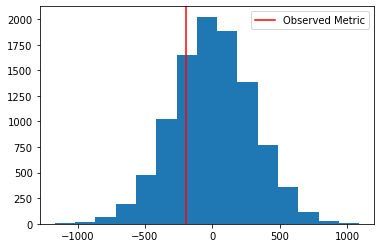

In [9]:
# Distribution of our null hypothesis
null_values = np.random.normal(0, np.std(sample_diffs), 10000)
plt.hist(null_values, bins='sturges')
plt.axvline(calculate_diff(train_data), color='r', label="Observed Metric")
plt.legend();

In [10]:
# Getting p-value for our train_data
z = (calculate_diff(train_data)) / np.std(sample_diffs)
p_value = 2 * stats.norm.cdf(z)
print("P-value:", p_value)

P-value: 0.5076929610510039


We cant reject the null hypothesis, because the difference isin't statistically significant

# Evaluation metrics

In [11]:
def calc_irr_nir(df):
    '''
    Function for calculating IRR (Incremental Response Rate) and NIR (Net Incremental Revenue)
    
    input: Pandas dataframe
    
    return: IRR, NIR
    '''
    purch_treat = df.query("Promotion == 'Yes'").query('purchase == 1').shape[0]
    purch_ctrl = df.query("Promotion == 'No'").query('purchase == 1').shape[0]
    cust_treat = df.query("Promotion == 'Yes'").shape[0]
    cust_ctrl = df.query("Promotion == 'No'").shape[0]
    
    IRR = (purch_treat / cust_treat) - (purch_ctrl / cust_ctrl)
    NIR = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl
    return IRR, NIR

In [17]:
IRR, NIR = calc_irr_nir(train_data)

# Hypothesis  Test on IRR and NIR

We want to perform a hypothesis test to see if the experiment has shown statistical significance results.

## IRR

We'll first apply bootstrap on our sampling for IRR evaluation

In [13]:
n_trials = 1000
n_points = train_data.shape[0]
sample_irrs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric (IRR)...
    sample_irr, _ = calc_irr_nir(sample)
        
    # and add the value to the list of sampled IRR
    sample_irrs.append(sample_irr)
    
# Compute the confidence interval bounds
lower_limit = np.percentile(sample_irrs, (1 - .975)/2 * 100)
upper_limit = np.percentile(sample_irrs, (1 + .975)/2 * 100)

print("Confidence intervals (Overall Type I error rate = 0.025):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Overall Type I error rate   = 0.025):
Lower Limit: 0.00773670811018011 
Upper Limit: 0.011157418530724217


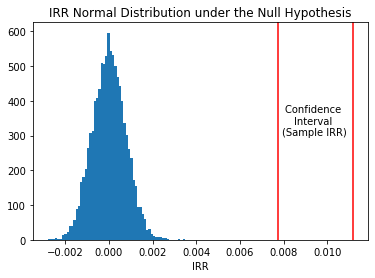

In [14]:
null_IRRs = np.random.normal(0, np.std(sample_irrs), 10000)
plt.hist(null_IRRs, bins='sturges')
plt.title("IRR Normal Distribution under the Null Hypothesis")
plt.xlabel('IRR')
plt.axvline(lower_limit, color='r')
plt.axvline(upper_limit, color='r')
plt.text(lower_limit+0.0002, 300, 'Confidence \nInterval \n(Sample IRR)', ma='center');

In [18]:
# Get the p-value
p_value = 1 - stats.norm.cdf(IRR, 0, np.std(sample_irrs))
print('P-Value:', p_value)

P-Value: 0.0


The p-value being lower than our alpha has shown statistically significant results for the IRR metric.

## NIR

In [25]:
n_trials = 1000
n_points = train_data.shape[0]
sample_nirs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric (NIR)...
    _, sample_nir = calc_irr_nir(sample)
        
    # and add the value to the list of sampled NIR
    sample_nirs.append(sample_nir)
    
#Compute the confidence interval bounds
lower_limit = np.percentile(sample_nirs, (1 - .975)/2 * 100)
upper_limit = np.percentile(sample_nirs, (1 + .975)/2 * 100)

print("Confidence intervals (Type I error rate   = 0.025):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Type I error rate   = 0.025):
Lower Limit: -3056.1062499999994 
Upper Limit: -1664.9131249999991


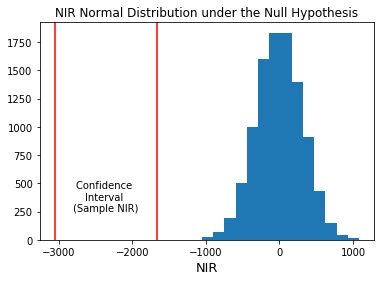

In [28]:
#plot distribution of our null hypothesis
null_NIRs = np.random.normal(0, np.std(sample_nirs), 10000)
plt.hist(null_NIRs, bins='sturges')
plt.title("NIR Normal Distribution under the Null Hypothesis")
plt.xlabel('NIR', fontsize=13)
plt.axvline(lower_limit, color='r')
plt.axvline(upper_limit, color='r')
plt.text(lower_limit+250, 250, 'Confidence \nInterval \n(Sample NIR)', ma='center');

In [29]:
# Calculate p-value
p_value = 1 - stats.norm.cdf(NIR, 0, np.std(sample_nirs))
print("P-Value:", p_value)

P-Value: 0.9999999999999436


P-value being above our alpha means we fail to reject the null hypothesis.

It means that the experiment doesn't shows good results in our NIR metric.

# Part III: Building prediction model

Why build a machine learning model? 

Because this way we can use the model to predict users who will show the best response for the promotions and possibly improving our NIR metric

for this test, we'll use RidgeClassifierCV and random forest

In [60]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [39]:
X = train_data.iloc[:, 3:]
Y = train_data['purchase']

In [108]:
X_train.dropna(inplace= True)
y_train.dropna(inplace = True)

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### random forest

In [33]:
pipeline = Pipeline([
    ('RandomForest', RandomForestClassifier())
])

In [43]:
pipeline.get_params()

{'memory': None,
 'steps': [('RandomForest', RandomForestClassifier())],
 'verbose': False,
 'RandomForest': RandomForestClassifier(),
 'RandomForest__bootstrap': True,
 'RandomForest__ccp_alpha': 0.0,
 'RandomForest__class_weight': None,
 'RandomForest__criterion': 'gini',
 'RandomForest__max_depth': None,
 'RandomForest__max_features': 'auto',
 'RandomForest__max_leaf_nodes': None,
 'RandomForest__max_samples': None,
 'RandomForest__min_impurity_decrease': 0.0,
 'RandomForest__min_impurity_split': None,
 'RandomForest__min_samples_leaf': 1,
 'RandomForest__min_samples_split': 2,
 'RandomForest__min_weight_fraction_leaf': 0.0,
 'RandomForest__n_estimators': 100,
 'RandomForest__n_jobs': None,
 'RandomForest__oob_score': False,
 'RandomForest__random_state': None,
 'RandomForest__verbose': 0,
 'RandomForest__warm_start': False}

In [86]:
parameters = {'RandomForest__n_estimators': [0, 50, 100],
             #'RandomForest__min_samples_leaf': [30, 40],
             #'RandomForest__min_samples_split': [100, 50],
             'RandomForest__criterion': ['gini', 'entropy'],
             #'RandomForest__class_weight': ['balanced_subsample'],
             'RandomForest__max_depth': [3, 6]}

In [87]:
cv = GridSearchCV(pipeline, param_grid = parameters, n_jobs = -1, verbose = 2)

In [88]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.54478405 0.53586751        nan 0.65979829 0.67228098
        nan 0.53812765 0.52066573        nan 0.65647904 0.66204055]
  category=UserWarning


GridSearchCV(estimator=Pipeline(steps=[('RandomForest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RandomForest__class_weight': ['balanced_subsample'],
                         'RandomForest__criterion': ['gini', 'entropy'],
                         'RandomForest__max_depth': [3, 6],
                         'RandomForest__n_estimators': [0, 50, 100]},
             verbose=2)

In [89]:
y_pred = cv.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     27548
           1       0.02      0.50      0.04       349

    accuracy                           0.66     27897
   macro avg       0.50      0.58      0.41     27897
weighted avg       0.98      0.66      0.78     27897



In [92]:
def labeling(y):
    promotion_df = []
    for i in y:
        if i == 1:
            promotion_df.append('Yes')
        if i == 0:
            promotion_df.append('No')
            
    return np.asarray(promotion_df)

In [93]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    model_predict = cv.predict(df)
    
    promotion = labeling(model_predict)
    
    
    return promotion

In [95]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0193.

Your nir with this strategy is 290.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019301111278950758, 290.54999999999995)

### RidgeClassifierCV

In [97]:
pipeline = Pipeline([
    ('Ridge', RidgeClassifierCV())
])

In [100]:
pipeline.get_params()

{'memory': None,
 'steps': [('Ridge', RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])))],
 'verbose': False,
 'Ridge': RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
 'Ridge__alphas': array([ 0.1,  1. , 10. ]),
 'Ridge__class_weight': None,
 'Ridge__cv': None,
 'Ridge__fit_intercept': True,
 'Ridge__normalize': False,
 'Ridge__scoring': None,
 'Ridge__store_cv_values': False}

In [101]:
parameters = {
    'Ridge__fit_intercept':[True, False],
    'Ridge__normalize':[True, False]
}

In [116]:
cv = GridSearchCV(pipeline, verbose = 2, n_jobs = -1, param_grid = parameters)

In [106]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('Ridge',
                                        RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])))]),
             n_jobs=-1,
             param_grid={'Ridge__fit_intercept': [True, False],
                         'Ridge__normalize': [True, False]},
             verbose=2)

In [109]:
y_pred = cv.predict(X_test)

In [113]:
# this model overfited really bad.
# but our randomforest performed realy well given the bad data
print(classification_report(y_test, y_pred, zero_division = False))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27548
           1       0.00      0.00      0.00       349

    accuracy                           0.99     27897
   macro avg       0.49      0.50      0.50     27897
weighted avg       0.98      0.99      0.98     27897



Conclusion:

If the data was better ballanced between purchases, we could have an even better performance.<br>
But our RandomForest could possibly predict who to send the promotion for improving our NIR metric<br>